# Step 3. Remove outliers based on the price

The price value of the raw data has a very large range, as it is shown in the figure below. 
In this section we want to find and remove price outliers in order to be able to properly train our regressor.

In [30]:
import pandas as pd
import numpy as np
import time
%matplotlib inline

import MAD_functions as mad
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

In [31]:
data = pd.read_csv('raw/step2_output.csv',sep=";")

In [32]:
#reassign the index to have the surviving row correctly indexed (needed if one wants to drop other rows before the price analisis)
data.index = range(data.shape[0])

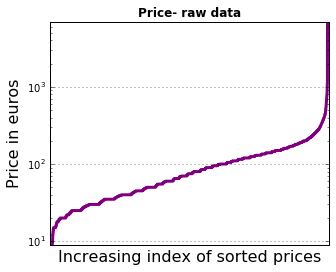

In [33]:
fig1 = plt.figure(figsize=(5,4))
ax = fig1.add_subplot(111)
a=plt.semilogy(np.sort(data.loc[:,('price')].values),'purple', Linewidth=3)
#b=plt.plot(np.sort(y_test),'k',Linewidth=3)
#c=plt.plot(y_median,'--b',Linewidth=2, label='median')
#d=plt.plot(y_mean,'--g',Linewidth=2, label='mean')
font = {'family' : 'Arial',
        'weight' : 'light',
        'size'   : 16}

ax.set_xlim(0-100, len(data.loc[:,('price')].values)+100)
ax.set_ylim(0, max(data.loc[:,('price')].values))

ax.set_xlabel('Increasing index of sorted prices',fontsize=16)
ax.set_ylabel('Price in euros', fontsize=16)

#ax.legend(frameon=False,loc=2,fontsize=14)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.title('Price- raw data',weight='bold')
fig1.set_alpha(0) #transparent background
ax.yaxis.grid(True)
plt.draw()

In [34]:
fig1.savefig('raw_data_price.png',dpi=600)

# Separating the three property types

In order to remove the outliers in the price feature, we should conisder the fact that the apartments are divided into three different property types: entire apartment, private room or shared room. This means that we should separate the thress populations in order to apply any statistical analysis to find the outliers.

In [35]:
#ler's get our boolean masks for the price:
#here we retrieve the three columns of interest as boolean vectors
entire_home=data.loc[:,('entire_home_apt')].values.astype(bool)
private=data.loc[:,('private_room')].values.astype(bool)
shared=data.loc[:,('shared_room')].values.astype(bool)

In [36]:
#here we use the boolean vectors to "filter" the price column and get three separate price vectors for the three categories
population_entire=data.loc[:,('price')].values[entire_home]
population_private=data.loc[:,('price')].values[private]
population_shared=data.loc[:,('price')].values[shared]

In [37]:
#let's get the indexes
index_entire=data.loc[:,('price')].index[entire_home]
index_private=data.loc[:,('price')].index[private]
index_shared=data.loc[:,('price')].index[shared]

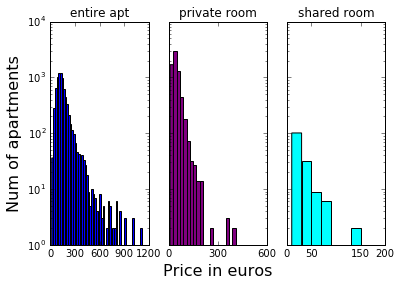

In [59]:
#Let's look at the price
binwidth=20
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

ax1.hist(population_entire, bins=np.arange(min(population_entire),max(population_entire) + binwidth, binwidth), facecolor='blue')
ax2.hist(population_private, bins=np.arange(min(population_private),max(population_private) + binwidth, binwidth),facecolor='purple')
ax3.hist(population_shared, bins=np.arange(min(population_shared),max(population_shared)+ binwidth, binwidth), facecolor='cyan')

ax1.set_title('entire apt')
ax2.set_title('private room')
ax3.set_title('shared room')
ax1.set_xlim(0,1200)
ax1.set_xticks([0, 300, 600, 900,1200])
ax2.set_xlim(0,600)
ax2.set_xticks([0, 300, 600])
ax3.set_xlim(0,200)
ax3.set_xticks([0, 50, 150, 200])

ax1.set_ylabel('Num of apartments',fontsize=16)

ax2.set_xlabel('Price in euros',fontsize=16)

plt.yscale('log', nonposy='clip')
plt.show()

#data = data.drop(data[data.price >= 400].index)


In [39]:
print np.median(population_entire), np.median(population_private), np.median(population_shared)
print mad.doubleMAD(population_entire), mad.doubleMAD(population_private), mad.doubleMAD(population_shared)

125.0 39.0 22.0
(30.0, 45.0) (10.0, 13.0) (3.0, 13.0)


# Applying the filter based on median and MAD to find the outliers

Now we calculate the MAD and use its value to define the the price limits to find and remove the outliers.
In particular, since the distributions are strongly asymmetrical, we will take the asymmetry into account computing the MAD separately for the data above and below the median, thus obtaining a MADlow and a MADhigh value, so our criteria of selection of good data becomes:

m-t x MADlow<x<m+t x MADhigh


In [40]:
thresh=8

In [41]:
#boolean maks for the good data we want to keep
good_entire=mad.doubleMAD_mask(data.loc[:,('price')].values[entire_home],thresh)
good_private=mad.doubleMAD_mask(data.loc[:,('price')].values[private],thresh)
good_shared=mad.doubleMAD_mask(data.loc[:,('price')].values[shared],thresh)

In [60]:
print np.sum(good_entire), np.sum(good_private), np.sum(good_shared)
print population_entire.size, population_private.size, population_shared.size
print population_entire.size-np.sum(good_entire), population_private.size-np.sum(good_private), population_shared.size-np.sum(good_shared)

7661 6627 150
7763 6706 154
102 79 4


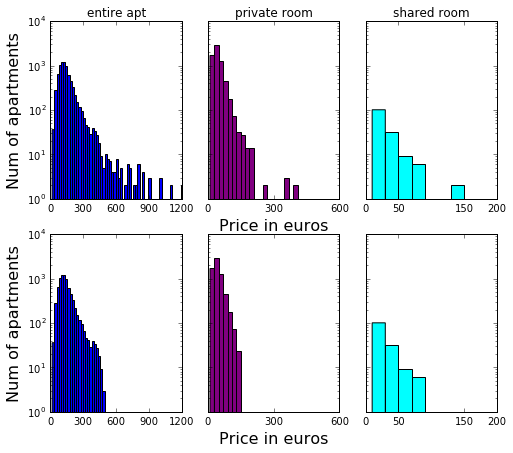

In [57]:
#let's look at what we will cut

binwidth=20
#f = plt.figure(figsize=(8,6))
f,((ax1, ax2, ax3),(ax4,ax5,ax6))= plt.subplots(2, 3, sharey=True,figsize=(8,7))
ax1.hist(population_entire, bins=np.arange(min(population_entire),max(population_entire) + binwidth, binwidth),facecolor='blue')
ax2.hist(population_private, bins=np.arange(min(population_private),max(population_private) + binwidth, binwidth),facecolor='purple')
ax3.hist(population_shared, bins=np.arange(min(population_shared),max(population_shared)+ binwidth, binwidth),facecolor='cyan')

ax4.hist(population_entire[good_entire], bins=np.arange(min(population_entire),max(population_entire) + binwidth, binwidth),facecolor='blue')
ax5.hist(population_private[good_private], bins=np.arange(min(population_private),max(population_private) + binwidth, binwidth),facecolor='purple')
ax6.hist(population_shared[good_shared], bins=np.arange(min(population_shared),max(population_shared)+ binwidth, binwidth),facecolor='cyan')

ax1.set_title('entire apt')
ax2.set_title('private room')
ax3.set_title('shared room')
ax1.set_xlim(0,1200)
ax1.set_xticks([0, 300, 600, 900,1200])
ax2.set_xlim(0,600)
ax2.set_xticks([0, 300, 600])
ax3.set_xlim(0,200)
ax3.set_xticks([0, 50, 150, 200])
ax4.set_xlim(0,1200)
ax4.set_xticks([0, 300, 600, 900,1200])
ax5.set_xlim(0,600)
ax5.set_xticks([0, 300, 600])
ax6.set_xlim(0,200)
ax6.set_xticks([0, 50, 150, 200])

ax1.set_ylabel('Num of apartments',fontsize=16)
ax4.set_ylabel('Num of apartments', fontsize=16)

ax2.set_xlabel('Price in euros',fontsize=16)
ax5.set_xlabel('Price in euros',fontsize=16)

plt.yscale('log', nonposy='clip')
plt.show()

In [58]:
f.savefig('outliers_price.png',dpi=600)

# Joining the three categories and outliers dropping

In [44]:
#from the individual bolean masks let's get an array with all the indeces of the rows we want to drop

outliers_entire= np.ones(len(good_entire),dtype=int)
outliers_entire= (outliers_entire-good_entire.astype(int)).astype(bool)
mask_entire=index_entire[outliers_entire]

outliers_private= np.ones(len(good_private),dtype=int)
outliers_private= (outliers_private-good_private.astype(int)).astype(bool)
mask_private=index_private[outliers_private]

outliers_shared= np.ones(len(good_shared),dtype=int)
outliers_shared= (outliers_shared-good_shared.astype(int)).astype(bool)
mask_shared=index_shared[outliers_shared]

full_mask=np.append(mask_entire,mask_private)
full_mask=np.append(full_mask,mask_shared)

In [45]:
full_mask=np.unique(full_mask)
#print full_mask, full_mask.size

In [46]:
#now apply the boolean mask using the indices
for ind in full_mask:
    data=data.drop(labels=ind, axis=0)
    
#data.drop(data.index[[ind, for ind in mask_entire]]) #this doesnt work but something similar, more pythonic than 
#the previous for should work...
data.shape

(14438, 160)

# Train-test splitting

In [47]:
'''Get 5 dataset to do cross validation
#prepare train and test groups and create two new dataframes
yfull = data.loc[:,'price'].copy()
xfull = data.copy()
xfull.drop('price', axis=1, inplace=True,errors='ignore')
random_seed=[1,42,3,121,17]
counter=1
for i in random_seed:
    x_train, x_test, y_train, y_test = train_test_split(xfull.values, yfull.values, test_size = .3, random_state = i)
    train=pd.DataFrame(x_train, columns=xfull.columns)
    train=train.join(pd.DataFrame(y_train,columns=['price']))
    test=pd.DataFrame(x_test, columns=xfull.columns)
    test=test.join(pd.DataFrame(y_test,columns=['price']))
    train.to_csv("raw/step3_output_train_"+str(counter)+".csv", sep=";", index=False, header=True)
    test.to_csv("raw/step3_output_test_"+str(counter)+".csv", sep=";", index=False, header=True)
    counter=counter+1'''

'Get 5 dataset to do cross validation\n#prepare train and test groups and create two new dataframes\nyfull = data.loc[:,\'price\'].copy()\nxfull = data.copy()\nxfull.drop(\'price\', axis=1, inplace=True,errors=\'ignore\')\nrandom_seed=[1,42,3,121,17]\ncounter=1\nfor i in random_seed:\n    x_train, x_test, y_train, y_test = train_test_split(xfull.values, yfull.values, test_size = .3, random_state = i)\n    train=pd.DataFrame(x_train, columns=xfull.columns)\n    train=train.join(pd.DataFrame(y_train,columns=[\'price\']))\n    test=pd.DataFrame(x_test, columns=xfull.columns)\n    test=test.join(pd.DataFrame(y_test,columns=[\'price\']))\n    train.to_csv("raw/step3_output_train_"+str(counter)+".csv", sep=";", index=False, header=True)\n    test.to_csv("raw/step3_output_test_"+str(counter)+".csv", sep=";", index=False, header=True)\n    counter=counter+1'

In [48]:
yfull = data.loc[:,'price'].copy()
xfull = data.copy()
xfull.drop('price', axis=1, inplace=True,errors='ignore')
x_train, x_test, y_train, y_test = train_test_split(xfull.values, yfull.values, test_size = .3, random_state = 1)
train=pd.DataFrame(x_train, columns=xfull.columns)
train=train.join(pd.DataFrame(y_train,columns=['price']))
test=pd.DataFrame(x_test, columns=xfull.columns)
test=test.join(pd.DataFrame(y_test,columns=['price']))

train.to_csv("raw/step3_output_train.csv", sep=";", index=False, header=True)
test.to_csv("raw/step3_output_test.csv", sep=";", index=False, header=True)

#data.to_csv("raw/step3_output.csv", sep=";", index=False, header=True)